BASELINE MODEL: SUPPORT VECTOR MACHINE (SVM) USING HOG (Histogram of Oriented Gradients) FEATURES (GOOD AT EDGE ORIENTATION)

SECTION 1: IMPORT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
from skimage import exposure
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

SECTION 2: CONFIGURATION

In [2]:
DATASET_PATH = '../../asl_dataset'
IMG_SIZE = 64
NUM_CLASSES = 36

CLASS_NAMES = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]
# str(i) converts num in range(10) to string ['0','1',...] 
# char(i) ng converts ASCII codes in range(65-91) to string (ASCII code for 'A' is 65, 'Z' 90)
# this way is less flexible

# Feature extraction method
FEATURE_METHOD = 'HOG' # THEN LETS TRY FLATTEN

print(f"\nConfiguration:")
print(f"  Dataset: {DATASET_PATH}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Feature method: {FEATURE_METHOD}")
print(f"  Classes: {NUM_CLASSES}")


Configuration:
  Dataset: ../../asl_dataset
  Image size: 64x64
  Feature method: HOG
  Classes: 36


SECTION 3: DATASET LOADING

In [3]:
def load_dataset(dataset_path, img_size):
    images = []
    labels = []
        
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.exists(class_path):
            print(f"Warning: Folder '{class_name}' not found!")
            continue
        
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            
            images.append(img)
            labels.append(class_idx)
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    
    print(f"✅ Loaded {len(images)} images")
    
    return images, labels

X, y = load_dataset(DATASET_PATH, IMG_SIZE)

# normalize
X = X / 255.0

# split 0.8/0.1/0.1
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nDataset split:")
print(f"a.  Training  : {len(X_train)} images")
print(f"b.  Validation: {len(X_val)} images")
print(f"c.  Test      : {len(X_test)} images")


✅ Loaded 7200 images

Dataset split:
a.  Training  : 5760 images
b.  Validation: 720 images
c.  Test      : 720 images


SECTION 4: FEATURE EXTRACTION

In [4]:
def extract_hog_features(images):
    features = []

    for i, img in enumerate(images):
        if i % 500 == 0:
            print(f"  Processing image {i}/{len(images)}...")
        
        # convert to grayscale for HOG
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        
        # extract HOG features
        fd = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=False)
        
        features.append(fd)
    
    return np.array(features)

start_time = time.time()

X_train_features = extract_hog_features(X_train)
X_val_features = extract_hog_features(X_val)
X_test_features = extract_hog_features(X_test)

extraction_time = time.time() - start_time

print(f"\n Feature extraction completed in {extraction_time:.2f} seconds")
print(f"a. Feature vector shape  : {X_train_features.shape}")
print(f"b. Feature dimensionality: {X_train_features.shape[1]}")


  Processing image 0/5760...
  Processing image 500/5760...
  Processing image 1000/5760...
  Processing image 1500/5760...
  Processing image 2000/5760...
  Processing image 2500/5760...
  Processing image 3000/5760...
  Processing image 3500/5760...
  Processing image 4000/5760...
  Processing image 4500/5760...
  Processing image 5000/5760...
  Processing image 5500/5760...
  Processing image 0/720...
  Processing image 500/720...
  Processing image 0/720...
  Processing image 500/720...

 Feature extraction completed in 11.70 seconds
a. Feature vector shape  : (5760, 1764)
b. Feature dimensionality: 1764


SECCTION 5: FEATURE SCALING

In [ ]:
# standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

print("Features standardized (mean=0, std=1) !")


Features standardized (mean=0, std=1)


SECTION 6: SVM TRAINING

In [ ]:
# Train SVM with RBF kernel
print("SVM Configuration: Kernel (RBF-Radial Basis Function), C: 1, Gamma: scale (automic)")

start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=1, 
    gamma='scale',
    probability=True, 
    random_state=42,
    verbose=False
)

svm_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print(f"\nSVM training completed in {training_time:.2f} seconds")
print(f"  Number of support vectors: {svm_model.n_support_.sum()}")


In [ ]:
'''
SVM Configuration: Kernel (RBF-Radial Basis Function), C: 1, Gamma: scale (automic)

SVM training completed in 55.80 seconds
Number of support vectors: 5413
'''

SECTION 7: EVALUATION

Making predictions on train, validation, and test sets...

 SVM Performance Summary:
a. Training Accuracy:   0.9932 (99.32%)
b. Validation Accuracy: 0.8667 (86.67%)
c. Test Accuracy:       0.8417 (84.17%)

🔍 Model Analysis:
  ⚠️ Possible overfitting detected!
     Train-Val gap: 12.66 percentage points
Consistent val-test performance


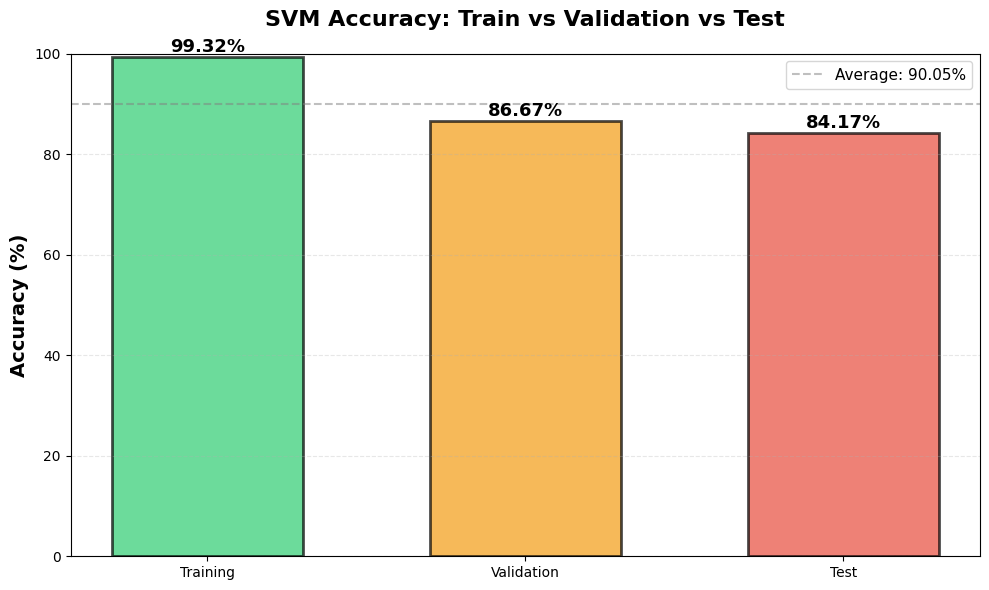

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

           0     0.9500    0.9500    0.9500        20
           1     1.0000    0.9500    0.9744        20
           2     0.9500    0.9500    0.9500        20
           3     1.0000    1.0000    1.0000        20
           4     0.8696    1.0000    0.9302        20
           5     1.0000    0.9000    0.9474        20
           6     0.9500    0.9500    0.9500        20
           7     0.9524    1.0000    0.9756        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    0.9500    0.9744        20
           A     0.8500    0.8500    0.8500        20
           B     0.9474    0.9000    0.9231        20
           C     0.8750    0.7000    0.7778        20
           D     0.8889    0.8000    0.8421        20
           E     0.9444    0.8500    0.8947        20
           F     0.8889    0.8000    0.8421        20
           G     0.8667    0.6500    0.7429     

In [ ]:

print("Making predictions on train, validation, and test sets...")

y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n SVM Performance Summary:")
print(f"a. Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"b. Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"c. Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Check for overfitting/underfitting
train_val_gap = train_accuracy - val_accuracy
val_test_gap = val_accuracy - test_accuracy

print(f"\n🔍 Model Analysis:")
if train_val_gap > 0.1:
    print(f"  ⚠️ Possible overfitting detected!")
    print(f"     Train-Val gap: {train_val_gap*100:.2f} percentage points")
elif train_val_gap < 0.02:
    print(f"Good generalization - minimal train-val gap")
else:
    print(f"Acceptable train-val gap: {train_val_gap*100:.2f}pp")

if abs(val_test_gap) > 0.05:
    print(f"  ⚠️ Val-Test gap: {val_test_gap*100:.2f}pp (somewhat large)")
else:
    print(f"Consistent val-test performance")

# Visualize accuracy comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

datasets = ['Training', 'Validation', 'Test']
accuracies = [train_accuracy * 100, val_accuracy * 100, test_accuracy * 100]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(datasets, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)

ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('SVM Accuracy: Train vs Validation vs Test', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, accuracies)):
    ax.text(bar.get_x() + bar.get_width()/2, v + 1, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=13)

# Add horizontal line for reference
avg_acc = np.mean(accuracies)
ax.axhline(y=avg_acc, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Average: {avg_acc:.2f}%')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("CLASSIFICATION REPORT (Test Set)")
report = classification_report(y_test, y_test_pred, target_names=CLASS_NAMES, digits=4)
print(report)

SECTION 8: CONFUSION MATRIX

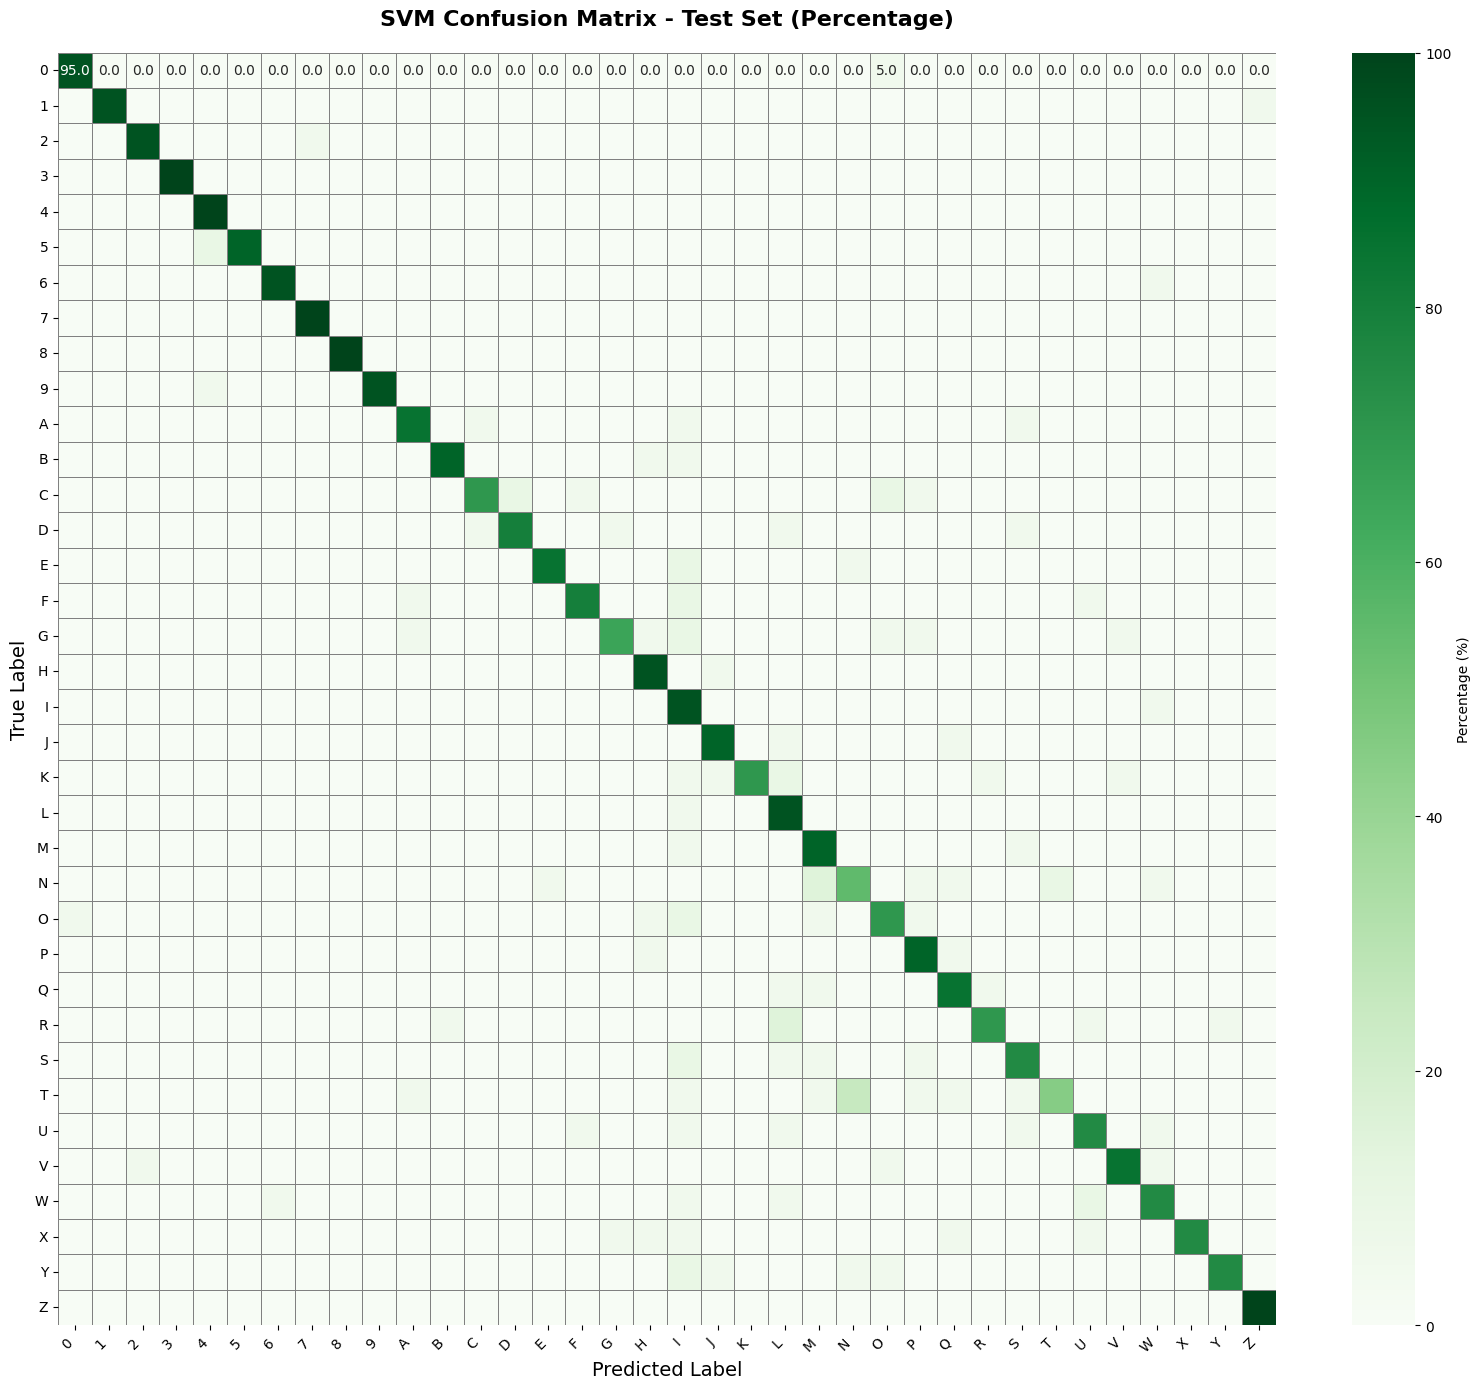

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Convert to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(16, 14))
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Percentage (%)'}, 
            linewidths=0.5, linecolor='gray')

plt.title('SVM Confusion Matrix - Test Set (Percentage)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()